# LSTM Encoder Decoder Architecture

We have used recurrent neural networks and long short term memory networks in word-level generation. These are systems that accumulate information i.e. encoding a sentence to generate the next word, based on a corpus of text. This is a many-to-one problem but we need to take this idea further for a many-to-many or sequence-to-sequence problem i.e. generating a phrase or another sentence based on a sentence; or summarisation or translation.

**LSTM vs RNN**

Because of backpropagation and the chain rule, when the gradient update is small, it decreases exponentially with the number of layers. Therefore, in very deep architectures with lots of layers, an update happening at a very deep layer doesn’t have any effect on the front layers (it vanishes), and the network can’t learn.

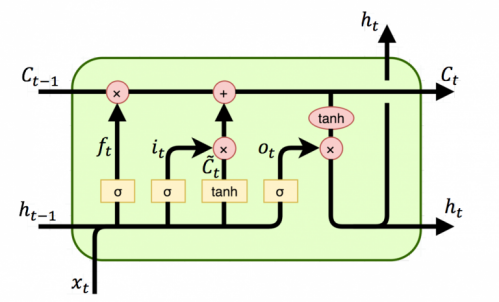

*   Cell state: This is the state of the cell (the memory)
*   Input gate: It regulates how much a new value can flow into the cell
*   Forget gate: It controls to what extent a new value remains in the cell
*   Output gate: It regulates the extent to which the value in the cell is used to compute the output activation of the LSTM unit



In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
root_folder = '/content/drive/My Drive/WordGeneration'

In [5]:
data = pd.read_csv(root_folder+'/FOMC2021.txt', sep="\n")

In [6]:
data.rename(columns={"Action to Adopt Changes to the Committee's Rules Regarding Availability of Information": "text"},
          inplace=True)
data["text"] = data["text"].str.replace("United States", "US")
data["text"] = data["text"].str.replace("U.S.", "US")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    486 non-null    object
dtypes: object(1)
memory usage: 3.9+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [7]:
func_folder = '/content/drive/My Drive/Colab Notebooks'

In [8]:
import sys
sys.path.append(func_folder)

In [9]:
import Contractions
from Contractions import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
def clean(text):
    text = re.sub('[0-9]+.\t', '', str(text)) # removing paragraph numbers
    text = re.sub('U.S.', 'USA', str(text))
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(' ')])
    text = re.sub('\n ', '', str(text))
    text = re.sub('\n', ' ', str(text))
    text = re.sub("'s", '', str(text))
    text = re.sub("-", ' ', str(text))
    text = re.sub("— ", '', str(text))
    text = re.sub('\"', '', str(text))
    text = re.sub("Mr\.", 'Mr', str(text))
    text = re.sub("Mrs\.", 'Mrs', str(text))
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    text = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', text) # add space around punctuation, i.e. treat them as token
    text = re.sub(r'\s\s', ' ', text)

    return text

In [11]:
data['text_clean'] = data['text'].apply(clean)

adj_lines = []
for i in data['text_clean']:
    if len(i.split()) >= 3:
        adj_lines.append(i)
adj_lines.append("startoken endtoken")

## Text Preprocessing

After cleaning the text and initial preprocessing, we use numpy and pandas operations to create training features of fixed length - i.e. governed by the number of words and also output sequence governed by a fixed number as well. This does away with padding. We also tokenize the entire text and create the necessary dictionaries.

The result is lists of the length required for both the input and output sequences. We then create train_test split and convert to numpy arrays for input into the encoder-decoder.

Note that in this case, with a seq-to-seq problem in the encoder-decoder architecture, we require start and end tokens, which must be unique with respect to the vocabulary of the existing text.

In [12]:
def sequence_generator(texts,
                      training_length, 
                      result_length, 
                      max_train=100000,
                      start_end_tokens=False,
                      lower=True):

    tokenizer = Tokenizer(lower=lower)
    tokenizer.fit_on_texts(texts)

    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'There are {num_words} unique words.')

    # import pickle
    # with open('tokenizer.pickle', 'wb') as handle:
    #     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    sequences = tokenizer.texts_to_sequences(texts)

    # Start-End tokens
    x = word_idx["startoken"]
    y = word_idx["endtoken"]

    # Limit to sequences with more than training length tokens
    seq_lengths = [len(x) for x in sequences]
    over_idx = [
        i for i, l in enumerate(seq_lengths) if l > (training_length + result_length + 3)]

    new_texts = []
    new_sequences = []

    # Only keep sequences with more than training length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])

    training_seq = []
    labels = []
    training_seq_words = []
    labels_words = []

    for seq in new_sequences:

        if len(training_seq) < max_train:
            for i in range(training_length, len(seq) - result_length):
                # Extract the features and label
                extract = seq[i - training_length:i + result_length]
                training_seq.append(extract[:training_length])
                if start_end_tokens:
                    label_adj = [x] + extract[training_length:] + [y]
                else: label_adj = extract[training_length:]
                labels.append(label_adj)

                training_seq_words.append([idx_word[j] for j in extract[:training_length]])
                labels_words.append([idx_word[j] for j in extract[training_length:]])

    print(f'There are {len(training_seq)} training sequences.')

    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels, \
           training_seq_words, labels_words

In [13]:
len_text = 30
len_result = 5

In [14]:
word_idx, idx_word, num_words, word_counts, new_texts, sequences, features, labels, training_seq_words, labels_words = \
    sequence_generator(
    adj_lines, training_length = len_text, result_length = len_result, start_end_tokens=True, lower=True)

There are 2955 unique words.
There are 42256 training sequences.


In [15]:
TRAIN_FRACTION = 0.7
RANDOM_STATE = 50

In [16]:
from sklearn.utils import shuffle

In [17]:
def create_train_valid(features,
                       labels,
                       num_words,
                       train_fraction=TRAIN_FRACTION):

    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)
    y_train, y_valid = np.array(train_labels), np.array(valid_labels)

    return X_train, X_valid, y_train, y_valid

In [18]:
x_tr, x_val, y_tr, y_val = create_train_valid(features, labels, num_words)

In [19]:
print(x_tr.shape, x_val.shape, y_tr.shape, y_val.shape)

(29579, 30) (12677, 30) (29579, 7) (12677, 7)


**GloVe word embeddings fitted to the training text.** Could train own embeddings by toggling embedding layer to trainable in the below. This is a distributed representation where each word is mapped to a fixed-sized vector of continuous values. The benefit of this approach is that different words with similar meaning will have a similar representation.

In [20]:
glove = np.loadtxt(root_folder+'/glove.6B.100d.txt', dtype='str', comments=None, encoding="utf8")
print(glove.shape)
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]
del glove

word_lookup = {word: vector for word, vector in zip(words, vectors)}
embedding_matrix = np.zeros((num_words, vectors.shape[1]))
not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

# Normalize and convert nan to 0
embedding_matrix = embedding_matrix / \
    np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

(400001, 101)
There were 132 words without pre-trained embeddings.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


## LSTM Encoder-Decoder Architecture

In [21]:
from keras import backend as K
import gensim
from numpy import *
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
import warnings

In [22]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
K.clear_session()

Create a function for encoder-decoder models. We include the toggle for trainability, based on the GloVe embeddings or train our own embedding based on the vocabulary size. Encoder LSTM layers can be any number, we will use three, and the **output** from each layer will feed into the next.

Finally, at the last layer, the **state_h** and **state_c** of the last LSTM layer will feed into the decoder LSTM layer.

The decoder similarly can be based on pre-trained embeddings or self-trained ones. The LSTM layer of the decoder will take the last encoder states and read through the output sequences to predict the next word.

In [ ]:
def encoder_decoder_model(len_text=len_text, embedding_dim=200, latent_dim=200, x_voc, y_voc, trainable=False, 
                          BiLSTM=False, LSTM_layers_enc=3):

    # ENCODER
    encoder_inputs = Input(shape=(len_text,))

    if not trainable:
        enc_emb = Embedding(num_words, 
                            embedding_matrix.shape[1], 
                            embeddings_initializer=Constant(embedding_matrix), 
                            trainable=False, name='enc_embedding')(encoder_inputs)
    else: enc_emb = Embedding(x_voc, embedding_dim, trainable=True, name='enc_embedding')(encoder_inputs)

    if BiLSTM:
        encoder_bilstm = BiLSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name='enc_BiLSTM')
        encoder_output1, state_h1, state_c1 = encoder_bilstm(enc_emb)
    
        if LSTM_layers_enc > 1:
            for i in range(LSTM_layers_enc - 1):
                encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name=f'enc_LSTM_{i}')
                encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_output1)

    else: 
      if LSTM_layers_enc > 1:
            for i in range(LSTM_layers_enc - 1):
                encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name=f'enc_LSTM_{i}')
                encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

    # DECODER
    decoder_inputs = Input(shape=(None,))

    if not trainable:
        dec_emb_layer = Embedding(num_words, 
                            embedding_matrix.shape[1], 
                            embeddings_initializer=Constant(embedding_matrix), 
                            trainable=False, name='enc_embedding')(decoder_inputs)
    else: dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True, name='enc_embedding')(decoder_inputs)  

    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
    decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    decoder_dense = TimeDistributed(Dense(num_words, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model

In [ ]:
model = encoder_decoder_model(len_text=len_text, embedding_dim=200, latent_dim=200, x_voc, y_voc, trainable=False,
                          BiLSTM=False, LSTM_layers_enc=3)

In [ ]:
"""
latent_dim = 200

encoder_inputs = Input(shape=(len_text,))
enc_emb = Embedding(num_words, embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix), trainable=False)(encoder_inputs)
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_words, embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix), trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_dense = TimeDistributed(Dense(num_words, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
"""

In [63]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      295500      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 30, 200),    240800      ['embedding[0][0]']              
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                            

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history = model.fit([x_tr, y_tr[:, :-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:], epochs=50,
                    callbacks=[es], batch_size=128,
                    validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))

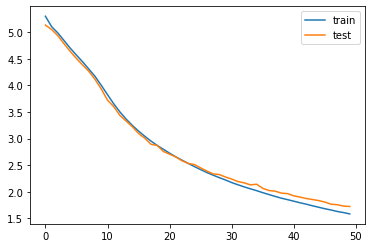

In [65]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [72]:
model.save(root_folder+"FOMC_EncoderDecoder2")
print("Saved model to disk")

INFO:tensorflow:Assets written to: /content/drive/My Drive/WordGenerationFOMC_EncoderDecoder2/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/WordGenerationFOMC_EncoderDecoder2/assets


Saved model to disk


**Load Model...**

In [26]:
from keras.models import load_model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.load_weights('/content/drive/My Drive/WordGenerationFOMC_EncoderDecoder2')

In [70]:
history = model.fit([x_tr, y_tr[:, :-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:], epochs=20,
                    callbacks=[es], batch_size=128,
                    validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))

Epoch 1/20
232/232 [==============================] - 155s 666ms/step - loss: 1.0481 - val_loss: 1.1963
Epoch 2/20
232/232 [==============================] - 151s 650ms/step - loss: 1.0426 - val_loss: 1.1785
Epoch 3/20
232/232 [==============================] - 152s 654ms/step - loss: 1.0321 - val_loss: 1.1805
Epoch 4/20
232/232 [==============================] - 151s 652ms/step - loss: 1.0291 - val_loss: 1.1657
Epoch 5/20
232/232 [==============================] - 150s 647ms/step - loss: 1.0203 - val_loss: 1.1640
Epoch 6/20
232/232 [==============================] - 150s 647ms/step - loss: 1.0168 - val_loss: 1.1709
Epoch 7/20
232/232 [==============================] - 152s 654ms/step - loss: 1.0091 - val_loss: 1.1548
Epoch 8/20
232/232 [==============================] - 151s 649ms/step - loss: 0.9999 - val_loss: 1.1463
Epoch 9/20
232/232 [==============================] - 152s 656ms/step - loss: 0.9964 - val_loss: 1.1626
Epoch 10/20
232/232 [==============================] - 150s 649m

In [27]:
reverse_target_word_index = idx_word
reverse_source_word_index = idx_word
target_word_index = word_idx

## Inference

**Define the encoder and decoder models** - Encode the input sequence to get the feature vector after feeding in the whole sequence. State_h and state_c not necessary.

Then create the decoder with the embedding layer, and to get the next word in the sequence, set the initial states to the state from the previous time step.

In [28]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [29]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(len_text, latent_dim))

In [30]:
dec_emb2 = dec_emb_layer(decoder_inputs)

In [31]:
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2,
                                                    initial_state=[decoder_state_input_h, decoder_state_input_c])

In [32]:
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [33]:
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [34]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['startoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if (sampled_token != 'endtoken'):
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'endtoken' or len(decoded_sentence.split()) >= (len_result + 3 - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [39]:
def seq2output(input_seq):
    newString = ''
    for i in input_seq:
        if ((i != 0 and i != target_word_index['startoken']) and i != target_word_index['endtoken']):
            newString = newString + reverse_target_word_index[i] + ' '
    return newString

In [36]:
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if (i != 0):
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

In [40]:
for i in range(0, 20):
    print("Text:", seq2text(x_tr[i]))
    print("Original phrase:", seq2output(y_tr[i]))
    print("Predicted output:", decode_sequence(x_tr[i].reshape(1, len_text)))
    print("\n")

Text: a reduction in inflation risks to the economic outlook remain including from new variants of the virus the committee seeks to achieve maximum employment and inflation at the rate of 
Original phrase: 2 percent over the longer 
Predicted output:  2 percent over the longer


Text: yield increases and more appreciation in their currencies in recent months over the intermeeting period the bank of canada announced a reduction in the pace of its asset purchases and 
Original phrase: brought forward its forecast of 
Predicted output:  brought its forecast forecast when


Text: be recalibrated often in response to incoming data or the evolving outlook participants also noted the importance of communicating to the public that the existing guidance together with the new 
Original phrase: monetary policy framework as delineated 
Predicted output:  monetary policy framework with the


Text: its holdings of treasury securities by at least 70 billion per month and of agency mortgage backed sec

In [60]:
def phrase_generator(i, iter):
    print("Text:", seq2text(x_tr[i]))

    tok = x_tr[i]
    output = ""
    output_phrase = decode_sequence(x_tr[i].reshape(1, len_text))

    for i in range(iter):
        output_tok = [word_idx[x] for x in output_phrase.split()]
        tok = np.append(tok, output_tok)[-len_text:]
        output_phrase = decode_sequence(tok.reshape(1, len_text))
        output = " ".join([output, output_phrase])

    output = re.sub(r'\s\s', ' ', output)
    print("-------> Follow:", output)

In [62]:
phrase_generator(i=10, iter=20)

Text: implications of incoming information for the economic outlook the committee would be prepared to adjust the stance of monetary policy as appropriate if risks emerge that could impede the attainment 
-------> Follow:  committee assessments will take into account a wide range of information including readings on public health labor market conditions inflation pressures and inflation expectations and inflation expectations and financial and persistently expectations and financial prices thereby moderately than in the intermeeting period to the committee seeks rate seen to a increase in the fourth increase as the overnight survey in the end of the 12‑month funds rate also expected for occur and market pricing however some participants pointed that the continued to be no as lower bound purchases purchases of the target meeting or could be potentially for a committee


In [63]:
phrase_generator(i=15, iter=20)

Text: moderation in the pace of the recovery indicators of economic activity and employment had turned up recently al­though the sectors most adversely affected by the pandemic remained weak inflation continued 
-------> Follow:  overall financial conditions remained accommodative in part reflecting policy measures to support the economy and the flow of credit to us households and businesses members also acknowledged that the path of the economy would depend significantly on the course of the virus progress on vaccinations would likely continue to reduce the effects of the public health crisis on the economy but risks to the economic outlook remain the committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run with inflation having run persistently below this longer run goal the committee will aim


In [64]:
phrase_generator(i=100, iter=20)

Text: noticeably in 2023 given the higher forecast for inflation the staff assumed monetary policy would be less accommodative in coming years and therefore revised down the medium term forecast for 
-------> Follow:  to remain well above 2 percent in 2023 and the period period but the low repo repo conditions in the spring of a range of average that had likely to be increased by a level in the seen in the average spreads facility by money and was level usage of the current reduction of the virus in addition real gdp was expected to rise in the second quarter the labor market desk survey of primary and continued to only additional notably in the january as the pandemic the unemployment rate for african americans though the recent number of job gains
